In [1]:
%matplotlib inline
import os.path
import sys
from inspect import getsourcefile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import linear_model, datasets, preprocessing
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import xgboost as xgb

# Custom modules
from aplib import aplib

In [2]:
# Customizable function to transform loss data
def transform_losses(losses):
    return np.log(losses + 700)

def inv_transform_losses(losses):
    return np.exp(losses) - 700

In [3]:
# Import data set
train_file_loc = os.path.expanduser("data/train.csv")
all_data = pd.read_csv(train_file_loc)

# Test data provided does not have losses, so use CV to create test sample
#test_file_loc = os.path.expanduser("~/Documents/springboard_files/springboard_cap1/data/test.csv")
#test_data = pd.read_csv(test_file_loc)

# Print sample data
all_data.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [4]:
# Load all data
#load_rows = 20000
load_rows = all_data.shape[0]
all_train_data = all_data.loc[:load_rows-1,:]
all_train_losses = all_data.loc[:load_rows-1,"loss"]

# Transform loss data
log_shift=700
log_shift_losses=True
if log_shift_losses==True:
    all_train_losses = transform_losses(all_train_losses)

# Create separate DataFrames for continuous and categorical variables
cat_var = all_train_data.iloc[:,1:117]
cont_var = all_train_data.iloc[:,117:-1]

# Encode categorical variables, re-join to continuous variables
#dummy_var = pd.get_dummies(cat_var, drop_first=True)
#all_train_data = pd.concat([dummy_var, cont_var], axis=1)

In [5]:
cat_var

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK
5,A,B,A,A,A,A,A,A,B,A,...,F,B,BI,CS,A,AS,AE,A,K,DJ
6,A,A,A,A,B,A,A,A,A,A,...,F,B,BI,DK,A,J,AF,A,K,DJ
7,A,B,A,B,A,A,A,A,B,A,...,I,G,BI,EB,G,AH,Y,A,P,LO
8,A,B,B,B,B,A,A,A,B,B,...,M,K,BI,BC,C,K,AX,A,Q,IE
9,A,B,A,A,B,B,A,A,B,A,...,J,G,BU,DW,A,U,S,J,O,LY


In [6]:
ratio_threshold = 1.1
le = preprocessing.LabelEncoder()
regr_onehot = linear_model.LinearRegression()
regr_le = linear_model.LinearRegression()

onehot_list = []
label_enc_list = []

for row in cat_var:
    if len(set(cat_var[row]))>2:
        onehot_vec = pd.get_dummies(cat_var[row], drop_first=True)
        label_enc_vec = le.fit_transform(cat_var[row])[:,None]
        regr_onehot.fit(onehot_vec, all_train_losses)
        regr_le.fit(label_enc_vec.reshape(-1,1), all_train_losses)
        ratio = regr_onehot.score(onehot_vec, all_train_losses) / regr_le.score(label_enc_vec.reshape(-1,1), all_train_losses)
        print "Variable: {0}, Number: {1}, One hot / LE score ratio: {2}".format(row, len(set(cat_var[row])), ratio)
        if ratio > ratio_threshold:
            onehot_list.append(row)
        else:
            label_enc_list.append(row)
    else:
        onehot_list.append(row)

Variable: cat73, Number: 3, One hot / LE score ratio: 1.00856134053
Variable: cat74, Number: 3, One hot / LE score ratio: 1.01060730174
Variable: cat75, Number: 3, One hot / LE score ratio: 1.00209749735
Variable: cat76, Number: 3, One hot / LE score ratio: 1.9318681963
Variable: cat77, Number: 4, One hot / LE score ratio: 1.66985228974
Variable: cat78, Number: 4, One hot / LE score ratio: 1.09142889995
Variable: cat79, Number: 4, One hot / LE score ratio: 1.08756584504
Variable: cat80, Number: 4, One hot / LE score ratio: 1.05032486316
Variable: cat81, Number: 4, One hot / LE score ratio: 1.16085514362
Variable: cat82, Number: 4, One hot / LE score ratio: 1.31754042408
Variable: cat83, Number: 4, One hot / LE score ratio: 1.52932302736
Variable: cat84, Number: 4, One hot / LE score ratio: 1.38700897601
Variable: cat85, Number: 4, One hot / LE score ratio: 1.1609918479
Variable: cat86, Number: 4, One hot / LE score ratio: 243.292335997
Variable: cat87, Number: 4, One hot / LE score rat

In [7]:
labl_enc_dummy_var = cat_var[label_enc_list].apply(lambda x: le.fit_transform(x))
onehot_dummy_var = pd.get_dummies(cat_var[onehot_list], drop_first=True)
all_train_data = pd.concat([onehot_dummy_var, labl_enc_dummy_var, cont_var], axis=1)

In [8]:
# Load test data
#test_load_rows = test_data.shape[0]
#test_data = test_data.loc[:test_load_rows-1,:]
#test_losses = test_data.loc[:test_load_rows-1,"loss"]
train_data, test_data, train_losses, test_losses = train_test_split(all_train_data,
                                                                    all_train_losses,
                                                                    test_size=0.1,
                                                                    random_state=3)

In [9]:
# Split categorical and continuos variables
cat_var_list = [col for col in list(train_data) if col.startswith('cat')]
cont_var_list = [col for col in list(train_data) if col.startswith('cont')]

In [10]:
# Check for completenes of data, returns 0 if there are entries for each loss data point
if sum(train_data.count(axis=0) != train_losses.size):
    print "Missing data mapped to losses"
else:
    print "No missing data mapped to losses"

No missing data mapped to losses


In [11]:
# For categorical variables, create dictionary of unique values
unique_dict = {}
for column in cat_var:
    unique_dict[column]=cat_var[column].unique()

{'lognorm': {'likeL': -148675.49562053062, 'AIC': 297356.99124106125, 'param': (0.28261843564772804, 5.8816360154115603, 2.0583985624965595)}, 'norm': {'likeL': -155467.0725846765, 'AIC': 310938.145169353, 'param': (8.023220512179762, 0.60552895239947013)}}


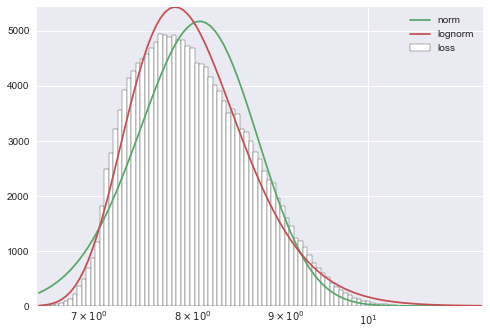

In [12]:
# List of distributional forms to explore
dist_names = ['norm','lognorm']#,'exponnorm', 'gamma']#, 'beta','norm', 'beta', 'rayleigh', 'norm', 'pareto']

# Call function to plot distribution and return fit information
figure, dist_info = aplib.fit_plot_distribution(train_losses, dist_names, log_scale=True)
print dist_info

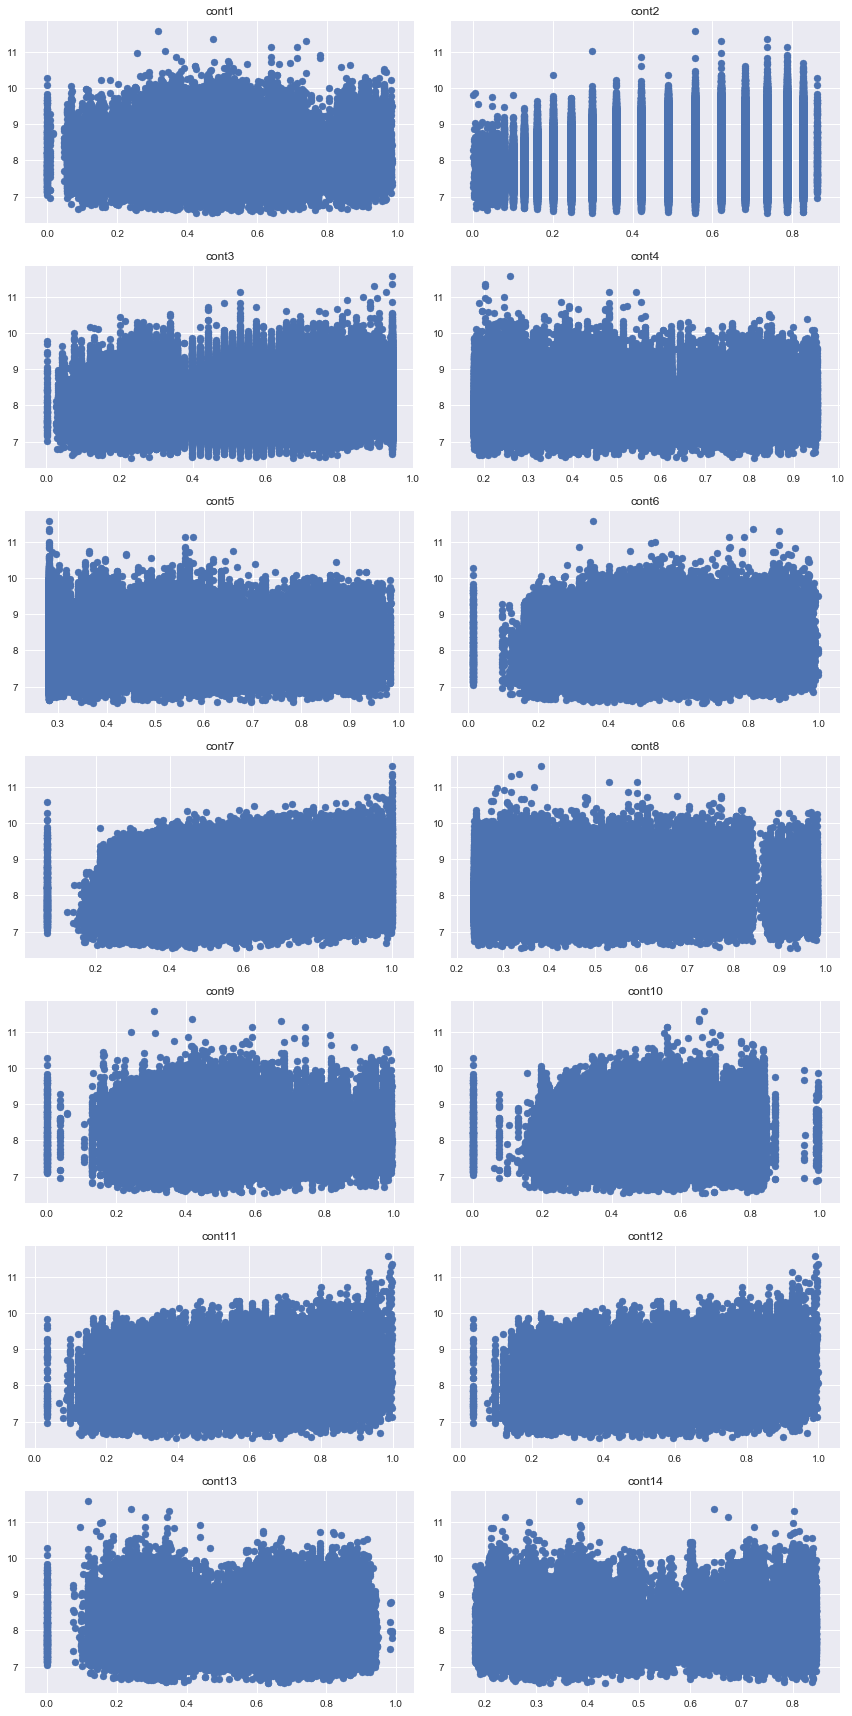

In [13]:
# Plot losses vs. continuous variables
fig, axes = plt.subplots(7,2, figsize=(12,24))

for counter, col in enumerate(cont_var_list):
    axes[counter // 2][counter % 2].scatter(x=train_data[col], y=train_losses)
    axes[counter // 2][counter % 2].set_title(col)

fig.tight_layout()

C:\Anaconda2\lib\site-packages\seaborn\palettes.py:725: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
C:\Anaconda2\lib\site-packages\seaborn\palettes.py:725: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
C:\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Anaconda2\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


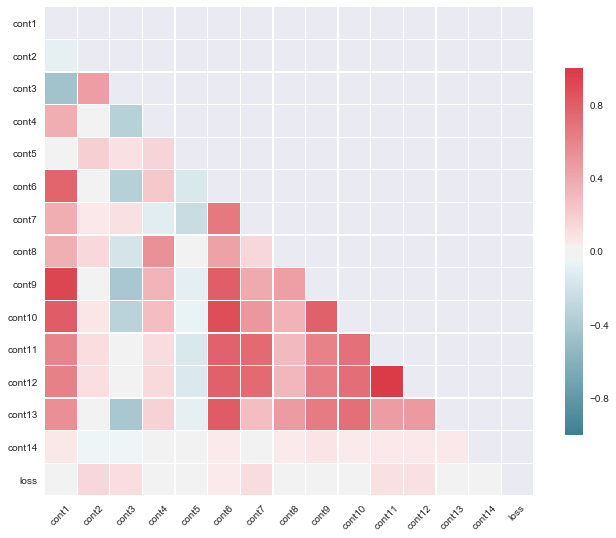

In [14]:
# Plot correlation matrix heat map
cont_var_wloss = all_data.iloc[:load_rows-1,117:]
corr = cont_var_wloss.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.25, cbar_kws={"shrink": .75}, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

In [15]:
# Identify variables with a degree of correlatin > threshold (between themselves or vs. loss)

threshold = 0.5
sig_dict = {}

sig_counter = 0
for counter1 in range(0, cont_var_wloss.columns.size):
    for counter2 in range(counter1 + 1, cont_var_wloss.columns.size):
        correl, pval = scipy.stats.pearsonr(cont_var_wloss.iloc[:,counter1], cont_var_wloss.iloc[:,counter2])
        if (correl<=-threshold) or (correl>=threshold):
            sig_dict[sig_counter] = {(cont_var_wloss.columns[counter1]):(cont_var_wloss.columns[counter2])}
            sig_counter += 1

sig_dict

{0: {'cont1': 'cont6'},
 1: {'cont1': 'cont9'},
 2: {'cont1': 'cont10'},
 3: {'cont1': 'cont11'},
 4: {'cont1': 'cont12'},
 5: {'cont1': 'cont13'},
 6: {'cont4': 'cont8'},
 7: {'cont6': 'cont7'},
 8: {'cont6': 'cont9'},
 9: {'cont6': 'cont10'},
 10: {'cont6': 'cont11'},
 11: {'cont6': 'cont12'},
 12: {'cont6': 'cont13'},
 13: {'cont7': 'cont11'},
 14: {'cont7': 'cont12'},
 15: {'cont9': 'cont10'},
 16: {'cont9': 'cont11'},
 17: {'cont9': 'cont12'},
 18: {'cont9': 'cont13'},
 19: {'cont10': 'cont11'},
 20: {'cont10': 'cont12'},
 21: {'cont10': 'cont13'},
 22: {'cont11': 'cont12'}}

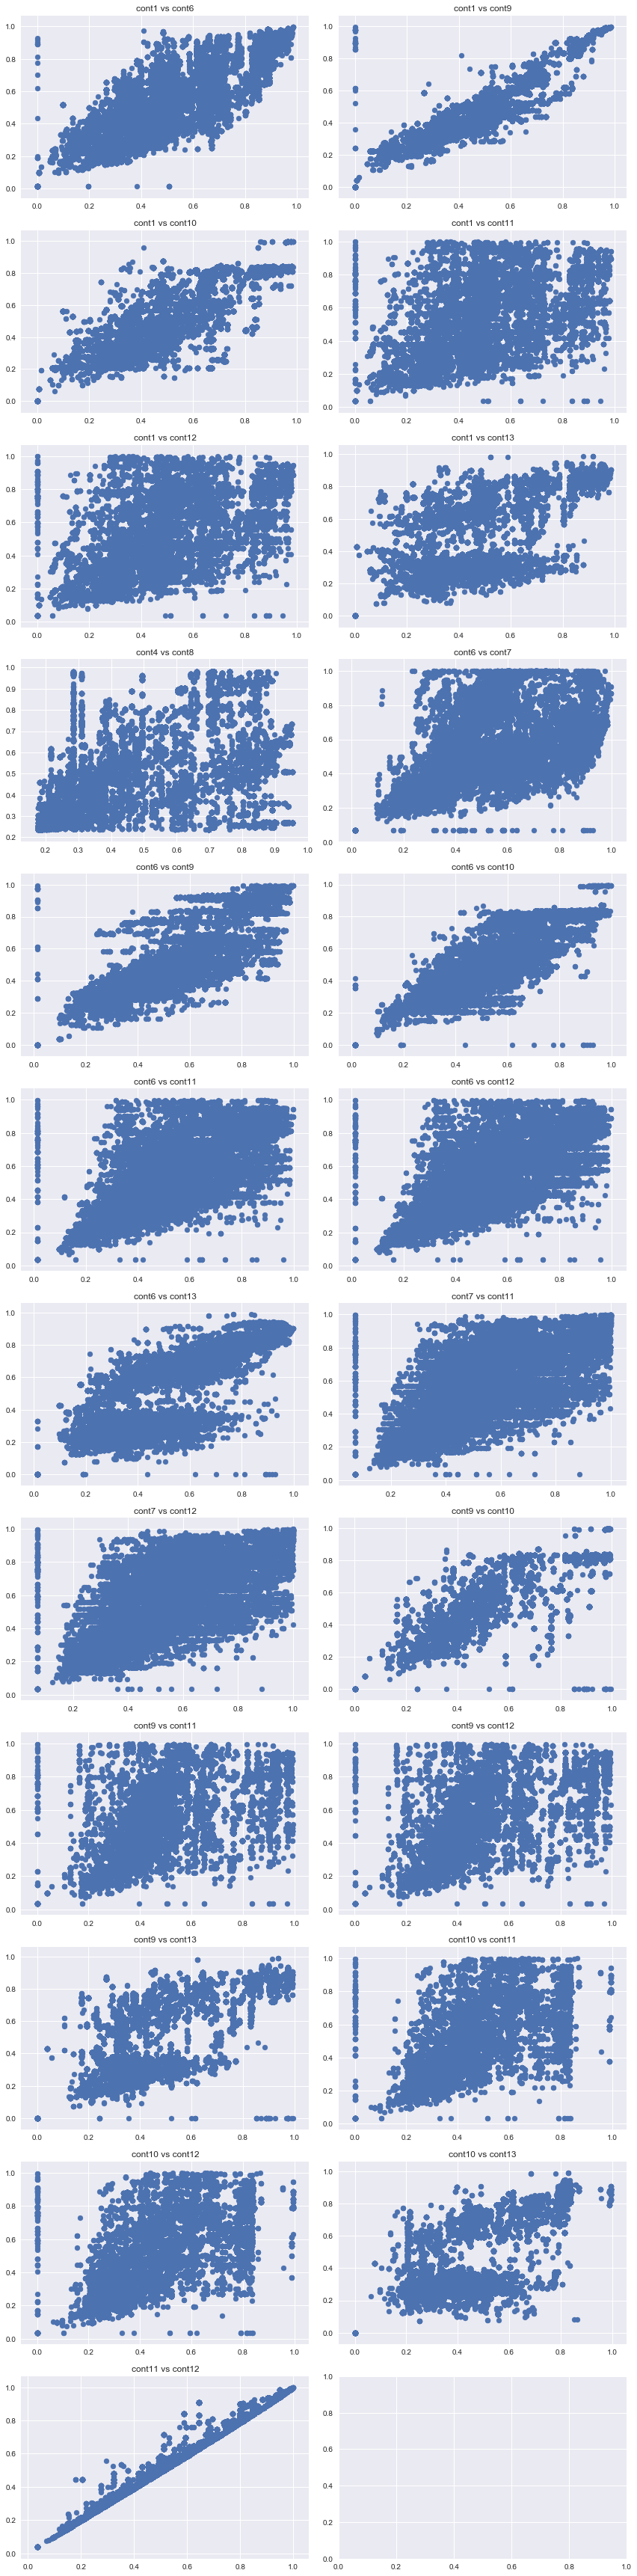

In [16]:
# Plot subset of continous variables and loss with a degree of correlation > threshold
fig, axes = plt.subplots(int(np.ceil((len(sig_dict)+1)/2)),2, figsize=(12,48))

for key, value in sig_dict.iteritems():
    title = ('{} vs {}').format(value.items()[0][0],  value.items()[0][1])
    axes[key // 2, key % 2].scatter(train_data[value.items()[0][0]], train_data[value.items()[0][1]])
    axes[key // 2, key % 2].set_title(title)

fig.tight_layout()

In [17]:
# Define cross validation scheme
kf_10 = KFold(n_splits=10, shuffle=False, random_state=2)

# Transform variables through PCA
cv_pca = PCA(whiten=False)

# Run through options for alpha parameter
regr = Ridge(fit_intercept=True)
param_grid = {'alpha': [0.1, 1, 10, 100]}
ridge_param_eval = GridSearchCV(regr, param_grid, cv=kf_10, scoring='neg_mean_absolute_error')
ridge_param_eval.fit(cv_pca.fit_transform(np.array(all_train_data)), np.array(all_train_losses))
ridge_param_eval.cv_results_

{'mean_fit_time': array([ 8.98870003,  9.14400003,  9.15559998,  9.14859998]),
 'mean_score_time': array([ 0.04719999,  0.04570003,  0.048     ,  0.04830003]),
 'mean_test_score': array([-0.32277913, -0.3226709 , -0.32256525, -0.32277879]),
 'mean_train_score': array([-0.3208798 , -0.32096849, -0.3212234 , -0.32183851]),
 'param_alpha': masked_array(data = [0.1 1 10 100],
              mask = [False False False False],
        fill_value = ?),
 'params': ({'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}, {'alpha': 100}),
 'rank_test_score': array([4, 2, 1, 3]),
 'split0_test_score': array([-0.32448845, -0.32434895, -0.32424725, -0.32467712]),
 'split0_train_score': array([-0.32072712, -0.32081261, -0.32106231, -0.3216546 ]),
 'split1_test_score': array([-0.32249607, -0.32241131, -0.32231927, -0.322612  ]),
 'split1_train_score': array([-0.32095162, -0.32104051, -0.32129407, -0.32190566]),
 'split2_test_score': array([-0.32180261, -0.32164158, -0.32159781, -0.3219313 ]),
 'split2_train_score

In [18]:
# Print out optimum parameter
opt_param = ridge_param_eval.cv_results_['params'][ridge_param_eval.cv_results_['rank_test_score'].argmin()]
print opt_param

{'alpha': 10}


In [19]:
# Optimal regression parameters based on analysis below
# For analyses based on PCA where variance of vectors is important, num_pca controls max number of features considered

ridge_reg_alpha = 10 #opt_param['alpha']
num_pca = []

In [20]:
# For analysis where variance of input data is an important feature does not whiten feature data
opt_regr = Ridge(alpha=ridge_reg_alpha)
max_factors = 110

# Identify PCA
pca = PCA(whiten=False)
all_var = pca.fit_transform(all_train_data)

# Add constant
all_var = np.insert(all_var, 0, 1, axis=1)

mse = []
for i in np.arange(0,max_factors):
    score = -cross_val_score(opt_regr, all_var[:,:i+1], 
                             all_train_losses, 
                             cv=kf_10, scoring='neg_mean_absolute_error').mean()
    mse.append(score)
    print 'Up to {0} PCA factors analyzed\r'.format(i+1),

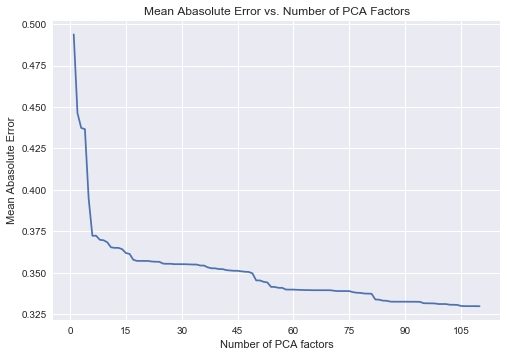

In [21]:
import matplotlib.ticker
fig,ax = plt.subplots()
ax.plot(np.arange(1,max_factors+1), mse[0:])
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel("Number of PCA factors")
#ax.set_xticks(np.arange(1,max_factors+1))
ax.set_ylabel("Mean Abasolute Error")
ax.set_title("Mean Abasolute Error vs. Number of PCA Factors")

Train R2: 0.54
Train MSE: 0.321
Test MAE: 0.323


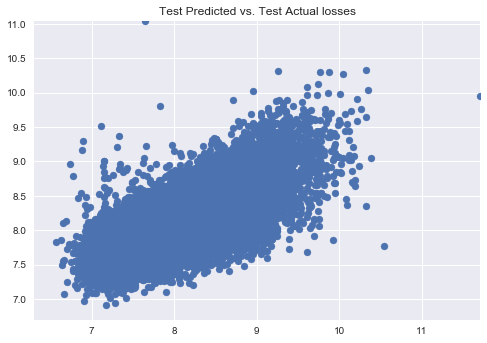

In [22]:
# Run all variables through OLS
% timeit
train_R2, train_MABS, test_MABS, test_scatter_plot, \
loss_pred, test_loss_pred = aplib.fit_OLS(losses=train_losses,
                                          test_losses=test_losses,
                                          X_train=train_data,
                                          X_test=test_data,
                                          apply_pca=True,
                                          ridge_alpha=ridge_reg_alpha)

In [23]:
if log_shift_losses==True:
    loss_pred = inv_transform_losses(loss_pred)
    test_loss_pred = inv_transform_losses(test_loss_pred)
    test_losses = inv_transform_losses(test_losses)
    train_losses = inv_transform_losses(train_losses)

1228.76994545
1227.32563369


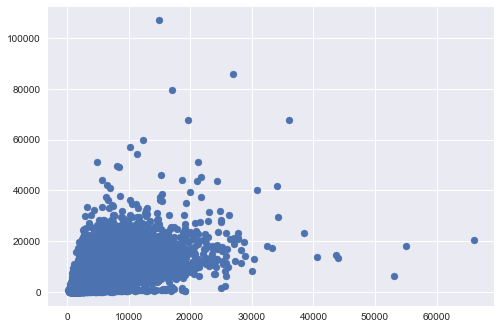

In [24]:
from sklearn.metrics import mean_absolute_error
print mean_absolute_error(test_loss_pred, test_losses)
print mean_absolute_error(loss_pred, train_losses)
plt.scatter(x=loss_pred, y=train_losses)